In [1]:
import pandas as pd
import numpy as np 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
from mplsoccer.pitch import Pitch, VerticalPitch
import requests

### 선수, 시즌 선택

In [90]:
#fill out necessarry information of about player and plot type here

player_id = 453 #undestat player id
is_season = True #if is_season = True, then specify season
season = 2022 #2020 corresponds to 2020/21 
highlight_goals = False

### 스크래핑

In [91]:
#data scraping 

def get_player_data(player_id):
    base = "https://understat.com/player/"
    base_url = base + str(player_id)
    url = base_url
    res = requests.get(url)
    soup = BeautifulSoup(res.content, "lxml")

    scripts = soup.find_all('script')
    strings = scripts[3].string

    ind_start = strings.index("('") + 2
    ind_end = strings.index("')")

    json_data = strings[ind_start:ind_end]
    json_data = json_data.encode('utf8').decode('unicode_escape')

    data = json.loads(json_data)

    finaldata = pd.DataFrame.from_dict(data)
    return finaldata

In [98]:
finaldata = get_player_data(player_id)

In [100]:
# Data Wrangling

# 수치형 변환

finaldata["X"] = pd.to_numeric(finaldata["X"])
finaldata["Y"] = pd.to_numeric(finaldata["Y"])
finaldata["season"] = pd.to_numeric(finaldata["season"])
finaldata["minute"] = pd.to_numeric(finaldata["minute"])
finaldata["xG"] = pd.to_numeric(finaldata["xG"])

# 라이브러리 구현을 위해 *120과 80을 해줘야 하나 봅니다

finaldata["X"] = finaldata["X"] * 120
finaldata["Y"] = finaldata["Y"] * 80  

In [102]:
# 페넕티 득점 제외
# "result", "X", "Y", "xG", "player", "season" 컬럼만 부름 

finaldata = finaldata[finaldata["situation"] != "Penalty"]
finaldata = finaldata[["result", "X", "Y", "xG", "player", "season"]]

In [103]:
if is_season == True:
        finaldata = finaldata[finaldata["season"] == season]
        
        year = {2014: "2014/15", 2015: "2015/16", 2016: "2016/17", 2017: "2017/18", 2018: "2018/19", 
                2019: "2019/20", 2020: "2020/21", 2021: "2021/22", 2022: "2022/23"}
        
        finaldata["season"] = finaldata["season"].map(year)
        
        szn = finaldata["season"].values[0]
        
        x = 45.2
        y = 62
        
elif is_season == False:
        finaldata["all"] = finaldata["season"]
        finaldata["all"] = "All Seasons"
        szn = finaldata["all"].values[0]
        x = 47
        y = 62

In [106]:
shot_col = '#C8102E'
goal_col = '#0000FF'

goal_df = finaldata[finaldata['result']=='Goal'].copy()
shot_df = finaldata[finaldata['result']!='Goal'].copy()

goal_cnt = goal_df.shape[0]
shot_cnt = shot_df.shape[0]
xg = finaldata['xG'].sum().round(2)

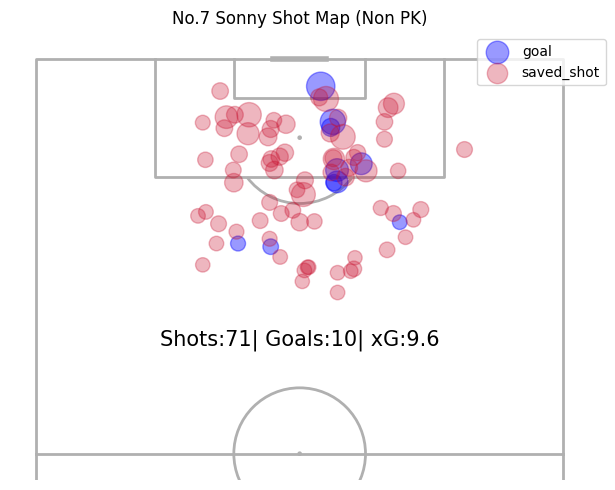

In [108]:
pitch = VerticalPitch(half=True)
fig,ax = pitch.draw(figsize=(10,5))

plt.title('No.7 Sonny Shot Map (Non PK)')

goal_sc = pitch.scatter(goal_df['X'],goal_df['Y'],
                   s=goal_df['xG']*500+100, # 크기 조정
                   c=goal_col, label = "goal", alpha=0.4,
                   ax=ax)

save_sc = pitch.scatter(shot_df['X'],shot_df['Y'],
                   s=shot_df['xG']*500+100, # 크기 조정
                   c=shot_col, label = "saved_shot", alpha=0.3,
                   ax=ax)

#fig.text(0.24,0.92, "Sonny's shot map in 2022/23",size=13, ha='left')

basic_info_txt = 'Shots:'+str(shot_cnt) + "| Goals:"+str(goal_cnt)+"| xG:"+str(xg)
fig.text(00.5,0.3,basic_info_txt,size=15,ha='center')

#ax.legend(labelspacing=1.5)
ax.legend(loc='upper right', bbox_to_anchor=(1.04, 1))